# Analysis of DQN vs. PPO on Atari Pong

This notebook performs the definitive analysis of the experimental results. It loads the `metrics.csv` from each individual run located in the `output/` directory, combines them into a master DataFrame, and then produces the publication-quality learning curves and quantitative summary tables required for the paper.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the global theme for all plots
sns.set_theme(style="whitegrid")

## 1. Load Real Experiment Data

This section scans the `output/` directory for all completed experiment runs, loads their respective `results/metrics.csv` files, and aggregates them into a single, master Pandas DataFrame for analysis. It automatically extracts the agent name and seed from the directory structure.

In [2]:
BASE_OUTPUT_DIR = '../output'
all_data = []

if not os.path.exists(BASE_OUTPUT_DIR):
    print(f"Error: Directory not found at '{BASE_OUTPUT_DIR}'. Please run training first.")
else:
    for run_dir_name in sorted(os.listdir(BASE_OUTPUT_DIR)):
        run_path = os.path.join(BASE_OUTPUT_DIR, run_dir_name)
        csv_path = os.path.join(run_path, 'results', 'metrics.csv')
        
        if os.path.isfile(csv_path):
            try:
                # Extract agent and seed from directory name (e.g., 'dqn_vanilla_42')
                parts = run_dir_name.rsplit('_', 1)
                agent_name = parts[0]
                seed = int(parts[1])
                
                df = pd.read_csv(csv_path)
                df['agent_name'] = agent_name
                df['seed'] = seed
                all_data.append(df)
                print(f"Successfully loaded data for: {run_dir_name}")
            except Exception as e:
                print(f"Could not process {csv_path}: {e}")

if all_data:
    results_df = pd.concat(all_data, ignore_index=True)
    print("\nMaster DataFrame created successfully!")
    print(f"Found {results_df['agent_name'].nunique()} agents across {results_df['seed'].nunique()} unique seeds.")
    display(results_df.head())
else:
    print("\nNo valid metrics.csv files found in the output directory.")

Successfully loaded data for: dqn_enhanced_126
Successfully loaded data for: dqn_enhanced_42
Successfully loaded data for: dqn_enhanced_84
Successfully loaded data for: dqn_vanilla_126
Successfully loaded data for: dqn_vanilla_42
Successfully loaded data for: dqn_vanilla_84

Master DataFrame created successfully!
Found 2 agents across 3 unique seeds.


,environment_frame,wall_clock_time_seconds,fps,eval_mean_return,eval_std_return,epsilon,q_learning_loss,mean_q_value,agent_name,seed
0,25000,53.860436,464.162600,-21.0,0.0,1.0000,NaN,NaN,dqn_enhanced,126
1,50000,107.515999,465.047067,-21.0,0.0,1.0000,NaN,NaN,dqn_enhanced,126
2,75000,244.132192,307.210611,-21.0,0.0,0.9775,0.000207,-0.032978,dqn_enhanced,126
3,100000,381.221786,262.314494,-21.0,0.0,0.9550,0.010290,-0.043515,dqn_enhanced,126
4,125000,519.726619,240.511060,-21.0,0.0,0.9325,0.000105,-0.045275,dqn_enhanced,126


## 2. Ablation Study: Vanilla DQN vs. Enhanced DQN

This plot directly compares the performance of the baseline `dqn_vanilla` agent against the `dqn_enhanced` agent. It visualizes the mean episodic return, averaged over three seeds, with the shaded region representing the 95% confidence interval. This figure is essential for Section 4.2 of the paper.

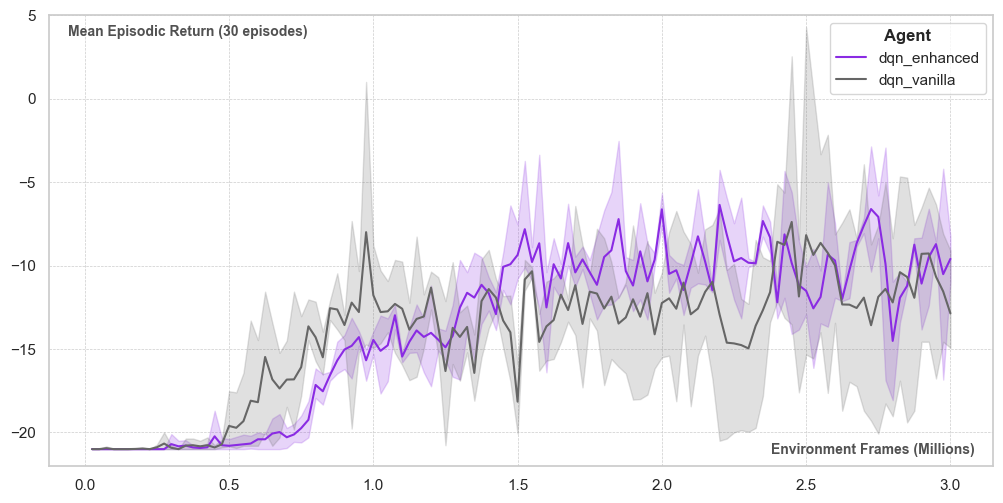

In [7]:
# --- Configuration for Publication-Quality Plots ---
PLOT_WIDTH_PX = 1000
PLOT_HEIGHT_PX = 500
PLOT_DPI = 100

COLOR_PALETTE = {
    'dqn_vanilla': (0.4, 0.4, 0.4),      # Dark Grey
    'dqn_enhanced': (0.54, 0.17, 0.89),   # Neon-Purple / Blue-Violet
    'ppo': (0.1, 0.7, 0.3)               # Vibrant Green
}

def plot_learning_curve_for_paper(df, title=None, x_col='environment_frame_millions', y_col='eval_mean_return', hue_col='agent_name'):
    """Generates a publication-quality learning curve."""
    width_inches = PLOT_WIDTH_PX / PLOT_DPI
    height_inches = PLOT_HEIGHT_PX / PLOT_DPI
    
    fig, ax = plt.subplots(figsize=(width_inches, height_inches), dpi=PLOT_DPI)

    sns.lineplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=hue_col,
        palette=COLOR_PALETTE,
        ax=ax,
        errorbar=('ci', 95),
        linewidth=1.5,
        alpha=1.0
    )

    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.text(0.02, 0.98, 'Mean Episodic Return (30 episodes)',
            transform=ax.transAxes, fontsize=10, fontweight='bold',
            verticalalignment='top', alpha=0.8)

    ax.text(0.98, 0.02, 'Environment Frames (Millions)',
            transform=ax.transAxes, fontsize=10, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right', alpha=0.8)

    legend = ax.legend(title='Agent')
    plt.setp(legend.get_title(), fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_ylim(-22, 5)
    
    if title:
        plt.suptitle(title, fontsize=16, fontweight='bold')
    
    plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.96] if title else [0, 0, 1, 1])
    plt.show()

# --- Data Processing and Plotting Call ---
if 'results_df' in locals() and not results_df.empty:
    eval_df = results_df.dropna(subset=['eval_mean_return']).copy()
    eval_df['environment_frame_millions'] = eval_df['environment_frame'] / 1_000_000

    ablation_df = eval_df[eval_df['agent_name'].isin(['dqn_vanilla', 'dqn_enhanced'])]
    plot_learning_curve_for_paper(ablation_df)
else:
    print("Cannot generate plot, as no data was loaded.")

## 3. Quantitative Summary Table Generation

This section processes the data from all runs to generate the final, aggregated metrics for the summary tables in the paper. It calculates the mean and standard deviation across seeds for key metrics like Final Score and Frames to Threshold.

In [4]:
if 'results_df' in locals() and not results_df.empty:
    summary_data = []
    AGENT_NAMES = results_df['agent_name'].unique()
    FINAL_EVALS = 5 # Use last 5 evaluation points for final score
    PERFORMANCE_THRESHOLD = 0.0 # Using a more realistic threshold for this data

    for agent_name in AGENT_NAMES:
        agent_df = eval_df[eval_df['agent_name'] == agent_name]
        final_scores, frames_to_threshold = [], []

        for seed in agent_df['seed'].unique():
            seed_df = agent_df[agent_df['seed'] == seed]
            
            # Calculate final score for this seed
            final_scores.append(seed_df.nlargest(FINAL_EVALS, 'environment_frame')['eval_mean_return'].mean())

            # Calculate frames to threshold for this seed
            if (seed_df['eval_mean_return'] >= PERFORMANCE_THRESHOLD).any():
                frames = seed_df[seed_df['eval_mean_return'] >= PERFORMANCE_THRESHOLD]['environment_frame'].min()
                frames_to_threshold.append(frames)
        
        summary_data.append({
            'Agent': agent_name,
            'Final Score (Mean)': np.mean(final_scores),
            'Final Score (Std)': np.std(final_scores),
            'Frames to Threshold (Mean)': np.mean(frames_to_threshold) if frames_to_threshold else np.nan,
            'Frames to Threshold (Std)': np.std(frames_to_threshold) if frames_to_threshold else np.nan,
        })

    summary_df = pd.DataFrame(summary_data)
    print("--- Quantitative Summary Table ---")
    display(summary_df)
else:
    print("Cannot generate summary, as no data was loaded.")

--- Quantitative Summary Table ---


,Agent,Final Score (Mean),Final Score (Std),Frames to Threshold (Mean),Frames to Threshold (Std)
0,dqn_enhanced,-10.088889,2.215530,NaN,NaN
1,dqn_vanilla,-10.733333,3.118323,1712500.0,737500.0
